# Monte Carlo -  MinGHG NoGC-AnF - SO

In [1]:
import swolfpy as sp
import swolfpy_inputdata as spid
import swolfpy_processmodels as sppm

import brightway2 as bw2
import pandas as pd
import numpy as np
from scipy import stats
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import platform
from IPython.display import Image

# Set font for plots
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "14"

# Set specs for pandas
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 700)
pd.set_option("precision", 2)

### SwolfPy version used to produced the results:

In [2]:
pd.DataFrame({'Version': [sp.__version__, sppm.__version__, spid.__version__]},
             index=['swolfpy', 'swolfpy_processmodels', 'swolfpy_inputdata'])

,Version
swolfpy,0.2.4
swolfpy_processmodels,0.1.9
swolfpy_inputdata,0.2.4


### System info

In [3]:
pd.DataFrame({'info': [platform.platform(),
                       platform.processor(),
                       os.cpu_count()]},
             index=['Platform', 'Processor', 'CPU_count'])

,info
Platform,Windows-10-10.0.19041-SP0
Processor,"Intel64 Family 6 Model 158 Stepping 9, GenuineIntel"
CPU_count,8


In [4]:
MC_Name = 'MC MinGHG-NoGC-AnF-SO'

n_iter = 5000
n_proc = os.cpu_count()

method = ('SwolfPy_Total_Cost', 'SwolfPy')

TotCost_Method = ('SwolfPy_Total_Cost', 'SwolfPy')
OptCost_Method = ('SwolfPy_Operational_Cost', 'SwolfPy')
CapCost_Method = ('SwolfPy_Capital_Cost', 'SwolfPy')
GWP_Method = ('IPCC 2013, Ecoinvent V3.5', 'climate change', 'GWP 100a, bioCO2=1, C1_36')
CED_Method = ('cumulative energy demand', 'fossil', 'non-renewable energy resources, fossil')
ACID_Method = ('TRACI (2.1) SwolfPy', 'environmental impact', 'acidification')
ETP_Method = ('TRACI (2.1) SwolfPy', 'environmental impact', 'eutrophication')
SMOG_Method = ('TRACI (2.1) SwolfPy', 'environmental impact', 'photochemical smog')
ETOX_Method = ('USEtox (obsolete)', 'ecotoxicity', 'total')
HTOX_Method = ('USEtox (obsolete)', 'human toxicity', 'total')

## Create project

In [5]:
project_name = 'MonteCarlo'
technosphere = sp.Technosphere(project_name=project_name, LCI_path="LCI_Data/Technosphere_LCI - NG-Elec.csv")
common_data = spid.CommonData()
ProcessMetaData = sppm.ProcessModelsMetaData.ProcessModelsMetaData

In [6]:
# Treatment processes
Treatment_processes = {}
Treatment_processes['LF'] = {'input_type':ProcessMetaData['LF']['InputType'] , 'model':sppm.LF()}
Treatment_processes['Composting'] = {'input_type':ProcessMetaData['Comp']['InputType'] , 'model':sppm.Comp()}
Treatment_processes['HC'] = {'input_type':ProcessMetaData['HC']['InputType'] , 'model':sppm.HC()}
Treatment_processes['AD'] = {'input_type':ProcessMetaData['AD']['InputType'] , 'model':sppm.AD()}
#Treatment_processes['AnF'] = {'input_type':ProcessMetaData['AnF']['InputType'] , 'model':sppm.AnF()}
Treatment_processes['SS_MRF'] = {'input_type':ProcessMetaData['SS_MRF']['InputType'] , 'model':sppm.SS_MRF()}
Treatment_processes['Reprocessing'] = {'input_type':ProcessMetaData['Reproc']['InputType'] , 'model':sppm.Reproc()}
#Treatment_processes['RDF'] = {'input_type':ProcessMetaData['RDF']['InputType'] , 'model':sppm.RDF()}
#Treatment_processes['GC'] = {'input_type':ProcessMetaData['GC']['InputType'] , 'model':sppm.GC()}
Treatment_processes['WTE'] = {'input_type':ProcessMetaData['WTE']['InputType'] , 'model':sppm.WTE()}

In [7]:
# Distance
#Processes = ['LF', 'Composting', 'HC', 'AD', 'AnF', 'SS_MRF', 'Reprocessing', 'RDF', 'GC', 'WTE', 'SF', 'MF', 'COM']
Processes = ['LF', 'Composting', 'HC', 'AD', 'SS_MRF', 'Reprocessing', 'WTE', 'SF', 'MF', 'COM']
data = sppm.Distance.create_distance_table(process_names=Processes,
                                           transport_modes=['Heavy Duty Truck'],
                                           default_dist=30)

distance = sppm.Distance(data)          
data['Heavy Duty Truck']

,LF,Composting,HC,AD,SS_MRF,Reprocessing,WTE,SF,MF,COM
LF,NaN,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
Composting,NaN,NaN,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
HC,NaN,NaN,NaN,30.0,30.0,30.0,30.0,30.0,30.0,30.0
AD,NaN,NaN,NaN,NaN,30.0,30.0,30.0,30.0,30.0,30.0
SS_MRF,NaN,NaN,NaN,NaN,NaN,30.0,30.0,30.0,30.0,30.0
Reprocessing,NaN,NaN,NaN,NaN,NaN,NaN,30.0,30.0,30.0,30.0
WTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,30.0,30.0
SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,30.0
MF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0
COM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Collection_processes:
Collection_processes = {}

SF_scheme = sppm.SF_Col.scheme()
SF_scheme[('RWC', 'SSO', 'SSR')] = 1
Collection_processes['SF'] = {'input_type': [],
                              'model': sppm.SF_Col('SF', SF_scheme,
                              Treatment_processes=Treatment_processes,
                              Distance=distance)}

MF_scheme = sppm.MF_Col.scheme()
MF_scheme[('RWC', 'SSO', 'SSR')] = 1
Collection_processes['MF'] = {'input_type': [],
                              'model': sppm.MF_Col('MF', MF_scheme,
                              Treatment_processes=Treatment_processes,
                              Distance=distance)}

COM_scheme = sppm.COM_Col.scheme()
COM_scheme[('RWC', 'SSO', 'SSR')] = 1
Collection_processes['COM'] = {'input_type': [],
                               'model': sppm.COM_Col('COM', COM_scheme,
                               Treatment_processes=Treatment_processes,
                               Distance=distance)}

In [9]:
population = 10**6
SF_density = 2.66
MF_density = 2.06
MF_fraction = 0.25
res_gen_rate = 1.12

# Composition data
comp_data = pd.read_csv('Composition Data/Updated Composition.csv', index_col=0)

# Set SF
Collection_processes['SF']['model'].process_data['Comp'] = comp_data['SingleFamily'].values
Collection_processes['SF']['model'].InputData.Col['res_per_dwel']['amount'] = SF_density
Collection_processes['SF']['model'].InputData.Col['houses_res']['amount'] = population * (1-MF_fraction) / SF_density
Collection_processes['SF']['model'].InputData.Col['res_gen']['amount'] = res_gen_rate

# Set MF
Collection_processes['MF']['model'].process_data['Comp'] = comp_data['MultiFamily'].values
Collection_processes['MF']['model'].InputData.Col['res_per_dwel']['amount'] = MF_density
Collection_processes['MF']['model'].InputData.Col['houses_res']['amount'] = population * MF_fraction / MF_density
Collection_processes['MF']['model'].InputData.Col['res_gen']['amount'] = res_gen_rate

# Set COM
Collection_processes['COM']['model'].process_data['Comp'] = comp_data['Restaurants'].values
Mass_Restaurants = 0.0549 * population - 2304.8
N_locations = 1000
Collection_processes['COM']['model'].InputData.Col['comm_gen']['amount'] = Mass_Restaurants / N_locations / (365/7) * 1000
Collection_processes['COM']['model'].InputData.Col['comm_loc']['amount'] = N_locations

## Define Uncertainty

In [10]:
from Set_MC import Set_MC
Set_MC(Treatment_processes, Collection_processes, common_data)

In [11]:
start = time()
demo = sp.Project(project_name, common_data, Treatment_processes, distance, Collection_processes, technosphere)
demo.init_project()
demo.write_project()
demo.group_exchanges()
print("Time for writing the project: {} second".format(round(time()-start)))

Biosphere database already present!!! No setup is needed
Vacuuming database 
Vacuuming database 


Writing activities to SQLite3 database:


Vacuuming database 

                ####
                ++++++  Writing the Technosphere
                


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:10:56
  Finished: 02/22/2022 17:11:12
  Total time elapsed: 00:00:15
  CPU %: 50.30
  Memory %: 1.38


Writing activities to SQLite3 database:



              ####
              ++++++ Initializing the LF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:13
  Finished: 02/22/2022 17:11:13
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 1.39

              ####
              ++++++ Initializing the Composting
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:13
  Finished: 02/22/2022 17:11:13
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 1.39


Writing activities to SQLite3 database:



              ####
              ++++++ Initializing the HC
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:13
  Finished: 02/22/2022 17:11:13
  Total time elapsed: 00:00:00
  CPU %: 104.20
  Memory %: 1.39


Writing activities to SQLite3 database:



              ####
              ++++++ Initializing the AD
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:13
  Finished: 02/22/2022 17:11:13
  Total time elapsed: 00:00:00
  CPU %: 146.50
  Memory %: 1.39


Writing activities to SQLite3 database:



              ####
              ++++++ Initializing the SS_MRF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:13
  Finished: 02/22/2022 17:11:13
  Total time elapsed: 00:00:00
  CPU %: 104.20
  Memory %: 1.39

              ####
              ++++++ Initializing the Reprocessing
              


Writing activities to SQLite3 database:
0% [###############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:13
  Finished: 02/22/2022 17:11:13
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 1.39

              ####
              ++++++ Initializing the WTE
              


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:14
  Finished: 02/22/2022 17:11:14
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 1.39

              ####
              ++++++ Initializing the SF
              


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:14
  Finished: 02/22/2022 17:11:14
  Total time elapsed: 00:00:00
  CPU %: 151.20
  Memory %: 1.39

              ####
              ++++++ Initializing the MF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:14
  Finished: 02/22/2022 17:11:14
  Total time elapsed: 00:00:00
  CPU %: 195.30
  Memory %: 1.39

              ####
              ++++++ Initializing the COM
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:14
  Finished: 02/22/2022 17:11:14
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 1.39


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the LF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:14
  Finished: 02/22/2022 17:11:15
  Total time elapsed: 00:00:01
  CPU %: 51.60
  Memory %: 1.40


Writing activities to SQLite3 database:



                  ####
                  ++++++ Writing the Composting_product
                  


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:16
  Finished: 02/22/2022 17:11:16
  Total time elapsed: 00:00:00
  CPU %: 33.20
  Memory %: 1.41

              ####
              ++++++ Writing the Composting
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:16
  Finished: 02/22/2022 17:11:16
  Total time elapsed: 00:00:00
  CPU %: 69.30
  Memory %: 1.42

              ####
              ++++++ Writing the HC
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:16
  Finished: 02/22/2022 17:11:16
  Total time elapsed: 00:00:00
  CPU %: 75.00
  Memory %: 1.42

                  ####
                  ++++++ Writing the AD_product
                  


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:17
  Finished: 02/22/2022 17:11:17
  Total time elapsed: 00:00:00
  CPU %: 133.00
  Memory %: 1.43

              ####
              ++++++ Writing the AD
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:17
  Finished: 02/22/2022 17:11:17
  Total time elapsed: 00:00:00
  CPU %: 59.90
  Memory %: 1.43

                  ####
                  ++++++ Writing the SS_MRF_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:17
  Finished: 02/22/2022 17:11:18
  Total time elapsed: 00:00:00
  CPU %: 61.70
  Memory %: 1.44


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the SS_MRF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:19
  Finished: 02/22/2022 17:11:19
  Total time elapsed: 00:00:00
  CPU %: 41.80
  Memory %: 1.46

              ####
              ++++++ Writing the Reprocessing
              


0% [###############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:19
  Finished: 02/22/2022 17:11:19
  Total time elapsed: 00:00:00
  CPU %: 66.50
  Memory %: 1.46

                  ####
                  ++++++ Writing the WTE_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:19
  Finished: 02/22/2022 17:11:19
  Total time elapsed: 00:00:00
  CPU %: 71.00
  Memory %: 1.46


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the WTE
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:20
  Finished: 02/22/2022 17:11:20
  Total time elapsed: 00:00:00
  CPU %: 58.30
  Memory %: 1.46

                  ####
                  ++++++ Writing the SF_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:21
  Finished: 02/22/2022 17:11:21
  Total time elapsed: 00:00:00
  CPU %: 60.10
  Memory %: 1.47


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the SF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:22
  Finished: 02/22/2022 17:11:22
  Total time elapsed: 00:00:00
  CPU %: 71.70
  Memory %: 1.48

                  ####
                  ++++++ Writing the MF_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:22
  Finished: 02/22/2022 17:11:23
  Total time elapsed: 00:00:00
  CPU %: 63.60
  Memory %: 1.48


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the MF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:23
  Finished: 02/22/2022 17:11:23
  Total time elapsed: 00:00:00
  CPU %: 66.50
  Memory %: 1.49

                  ####
                  ++++++ Writing the COM_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:24
  Finished: 02/22/2022 17:11:24
  Total time elapsed: 00:00:00
  CPU %: 70.10
  Memory %: 1.49


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the COM
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2022 17:11:25
  Finished: 02/22/2022 17:11:25
  Total time elapsed: 00:00:00
  CPU %: 57.30
  Memory %: 1.50

                  Grouping the exchanges with parameters in Database LF
                  

                  Grouping the exchanges with parameters in Database Composting
                  

                  Grouping the exchanges with parameters in Database HC
                  

                  Grouping the exchanges with parameters in Database AD
                  

                  Grouping the exchanges with parameters in Database SS_MRF
                  

                  Grouping the exchanges with parameters in Database Reprocessing
                  

                  Grouping the exchanges with parameters in Database WTE
                  

                  Grouping the exchanges with parameters in Database SF
                  

                  Grouping the exchanges with parameters in Databas

### Electricity from Natural gas

In [12]:
lca = bw2.LCA({('Technosphere', 'Electricity_production'):1}, GWP_Method)
lca.lci()
lca.lcia()
Elec_prod = round(lca.score, 2)

lca = bw2.LCA({('Technosphere', 'Electricity_consumption'):1}, GWP_Method)
lca.lci()
lca.lcia()
Elec_cosmp = round(lca.score, 2)

print(f"Electricity production GHG intensity: {Elec_prod} kg CO2 eq/kWh")
print(f"Electricity cosumption GHG intensity: {Elec_cosmp} kg CO2 eq/kWh")

Electricity production GHG intensity: -0.59 kg CO2 eq/kWh
Electricity cosumption GHG intensity: 0.62 kg CO2 eq/kWh


In [13]:
prms = [
    {'name': 'frac_of_Other_Residual_from_Composting_to_LF', 'amount': 0},
    {'name': 'frac_of_Other_Residual_from_Composting_to_WTE', 'amount': 1},
    {'name': 'frac_of_Other_Residual_from_AD_to_LF', 'amount': 0},
    {'name': 'frac_of_Other_Residual_from_AD_to_WTE', 'amount': 1},
    {'name': 'frac_of_Other_Residual_from_SS_MRF_to_LF', 'amount': 0},
    {'name': 'frac_of_Other_Residual_from_SS_MRF_to_WTE', 'amount': 1},
    {'name': 'frac_of_RWC_from_SF_to_LF', 'amount': 0},
    {'name': 'frac_of_RWC_from_SF_to_WTE', 'amount': 1},
    {'name': 'frac_of_SSO_from_SF_to_Composting', 'amount': 0},
    {'name': 'frac_of_SSO_from_SF_to_AD', 'amount': 1},
    {'name': 'frac_of_MRDO_from_SF_to_LF', 'amount': 0},
    {'name': 'frac_of_MRDO_from_SF_to_WTE', 'amount': 1},
    {'name': 'frac_of_RWC_from_MF_to_LF', 'amount': 0},
    {'name': 'frac_of_RWC_from_MF_to_WTE', 'amount': 1},
    {'name': 'frac_of_SSO_from_MF_to_Composting', 'amount': 0},
    {'name': 'frac_of_SSO_from_MF_to_AD', 'amount': 1},
    {'name': 'frac_of_RWC_from_COM_to_LF', 'amount': 0},
    {'name': 'frac_of_RWC_from_COM_to_WTE', 'amount': 1},
    {'name': 'frac_of_SSO_from_COM_to_Composting', 'amount': 0},
    {'name': 'frac_of_SSO_from_COM_to_AD', 'amount': 1}]

In [14]:
start = time()
demo.update_parameters(prms)
print("Time for updating the parameters: {} second".format(round(time()-start)))
demo.parameters_list

Time for updating the parameters: 16 second


[{'name': 'frac_of_Other_Residual_from_Composting_to_LF', 'amount': 0},
 {'name': 'frac_of_Other_Residual_from_Composting_to_WTE', 'amount': 1},
 {'name': 'frac_of_Other_Residual_from_AD_to_LF', 'amount': 0},
 {'name': 'frac_of_Other_Residual_from_AD_to_WTE', 'amount': 1},
 {'name': 'frac_of_Other_Residual_from_SS_MRF_to_LF', 'amount': 0},
 {'name': 'frac_of_Other_Residual_from_SS_MRF_to_WTE', 'amount': 1},
 {'name': 'frac_of_RWC_from_SF_to_LF', 'amount': 0},
 {'name': 'frac_of_RWC_from_SF_to_WTE', 'amount': 1},
 {'name': 'frac_of_SSO_from_SF_to_Composting', 'amount': 0},
 {'name': 'frac_of_SSO_from_SF_to_AD', 'amount': 1},
 {'name': 'frac_of_MRDO_from_SF_to_LF', 'amount': 0},
 {'name': 'frac_of_MRDO_from_SF_to_WTE', 'amount': 1},
 {'name': 'frac_of_RWC_from_MF_to_LF', 'amount': 0},
 {'name': 'frac_of_RWC_from_MF_to_WTE', 'amount': 1},
 {'name': 'frac_of_SSO_from_MF_to_Composting', 'amount': 0},
 {'name': 'frac_of_SSO_from_MF_to_AD', 'amount': 1},
 {'name': 'frac_of_RWC_from_COM_to_LF'

In [15]:
params_df = pd.DataFrame(demo.parameters_list)
for i, j in params_df['name'].items():
    if type(j) == str:
        j = j.strip('frac_of_')
        params_df.loc[i, 'From'] = j.split('_from_')[1].split('_to_')[0]
        params_df.loc[i, 'To'] = j.split('_from_')[1].split('_to_')[1]
        params_df.loc[i, 'Product'] = j.split('_from_')[0]
    else:
        params_df.loc[i, 'From'] = j[0]
        params_df.loc[i, 'Product'] = str(j[1])
params_df[['From', 'To', 'Product', 'amount']]

,From,To,Product,amount
0,Composting,LF,Other_Residual,0
1,Composting,WTE,Other_Residual,1
2,AD,LF,Other_Residual,0
3,AD,WTE,Other_Residual,1
4,SS_MRF,LF,Other_Residual,0
5,SS_MRF,WTE,Other_Residual,1
6,SF,LF,RWC,0
7,SF,WTE,RWC,1
8,SF,Composting,SSO,0
9,SF,AD,SSO,1


In [16]:
input_dict = {'SF':{}, 'MF':{}, 'COM':{}}

for key in common_data.Index:
    input_dict['SF'][key] = 1
    input_dict['MF'][key] = 1
    input_dict['COM'][key] = 1

demo.create_scenario(input_dict, 'Collection')

## Mass flows, impacts and costs based on default parameters

In [17]:
process_list = ['SF', 'MF', 'COM', 'LF', 'WTE', 'RDF', 'GC', 'Composting', 'AD', 'HC', 'AnF', 'SS_MRF', 'Reprocessing']
perform_index = ['Diversion', 'GWP', 'Operation Cost', 'Capital cost', 'Total cost',
                 'CED', 'Acidification', 'Eutrophication', 'Photochemical smog',
                 'Ecotoxicity', 'Human toxicity']
results = pd.DataFrame(columns=['Value', 'Unit'],
                       index=perform_index+process_list,)

bw2.projects.set_current(project_name)
Demand = {('waste', 'Collection'):1}
FU=bw2.get_activity(('waste', 'Collection'))
lca=bw2.LCA(Demand, GWP_Method)
lca.lci()
lca.lcia()
results.loc['GWP',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg CO2 eq/Mg']

lca.switch_method(OptCost_Method)
lca.lcia()
results.loc['Operation Cost',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), '$/Mg']


lca.switch_method(CapCost_Method)
lca.lcia()
results.loc['Capital cost',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), '$/Mg']

lca.switch_method(TotCost_Method)
lca.lcia()
results.loc['Total cost',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), '$/Mg']

lca.switch_method(CED_Method)
lca.lcia()
results.loc['CED',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'MJ eq/Mg']

lca.switch_method(ACID_Method)
lca.lcia()
results.loc['Acidification',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg SO2 eq/Mg']

lca.switch_method(ETP_Method)
lca.lcia()
results.loc['Eutrophication',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg N eq/Mg']

lca.switch_method(SMOG_Method)
lca.lcia()
results.loc['Photochemical smog',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'kg O3 eq/Mg']

lca.switch_method(ETOX_Method)
lca.lcia()
results.loc['Ecotoxicity',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'CTU/Mg']

lca.switch_method(HTOX_Method)
lca.lcia()
results.loc['Human toxicity',:] = [lca.score/float(FU.as_dict()['unit'].split(' ')[0]), 'CTU/Mg']


for process in process_list:
    results.loc[process,:] = [round(sp.LCA_matrix.LCA_matrix.get_mass_flow(lca, process)), 'Mg/yr']

results.loc['Diversion',:] = [(1 - results['Value']['LF'] / float(FU.as_dict()['unit'].split(' ')[0])) * 100, '%']
results.to_csv(f'{MC_Name}.csv')
results

,Value,Unit
Diversion,89.06,%
GWP,452.07,kg CO2 eq/Mg
Operation Cost,41.02,$/Mg
Capital cost,34.56,$/Mg
Total cost,75.59,$/Mg
CED,-7409.59,MJ eq/Mg
Acidification,-4.05,kg SO2 eq/Mg
Eutrophication,0.42,kg N eq/Mg
Photochemical smog,3.93,kg O3 eq/Mg
Ecotoxicity,-4899.79,CTU/Mg


## Monte Carlo simulation

In [18]:
process_models = []
process_model_names = []

methods = [TotCost_Method, OptCost_Method, CapCost_Method, GWP_Method,
           CED_Method, ACID_Method, ETP_Method, SMOG_Method, ETOX_Method,
           HTOX_Method]

for P in demo.Treatment_processes:
    process_models.append(demo.Treatment_processes[P]['model'])
    process_model_names.append(P)

mc = sp.Monte_Carlo(functional_unit=Demand,
                    method=methods,
                    project=demo.project_name,
                    process_models=process_models,
                    process_model_names= process_model_names,
                    seed=0)
start = time()
mc.run(n_proc, n_iter)
print(f"time = {round((time()-start)/60, 1)} min")

time = 9.2 min


In [19]:
mc_results=mc.result_to_DF()
mc_results.to_pickle(f'{MC_Name} results.pickle')
mc_results.head()

,"(SwolfPy_Total_Cost, SwolfPy)","(SwolfPy_Operational_Cost, SwolfPy)","(SwolfPy_Capital_Cost, SwolfPy)","(IPCC 2013, Ecoinvent V3.5, climate change, GWP 100a, bioCO2=1, C1_36)","(cumulative energy demand, fossil, non-renewable energy resources, fossil)","(TRACI (2.1) SwolfPy, environmental impact, acidification)","(TRACI (2.1) SwolfPy, environmental impact, eutrophication)","(TRACI (2.1) SwolfPy, environmental impact, photochemical smog)","(USEtox (obsolete), ecotoxicity, total)","(USEtox (obsolete), human toxicity, total)","(LF, Landfill operation parameteres, annWaste)","(LF, Landfill operation parameteres, optime)","(LF, Landfill Gas Parameters, actk)","(LF, Landfill Gas Parameters, initColEff)","(LF, Landfill Gas Parameters, intColEff)","(LF, Landfill Gas Parameters, incColEff)","(LF, Landfill Gas Parameters, finColEff)","(LF, Energy_Rec, convEff)","(LF, Operational_Cost, Yard_Trimmings_Leaves)","(LF, Operational_Cost, Yard_Trimmings_Grass)","(LF, Operational_Cost, Yard_Trimmings_Branches)","(LF, Operational_Cost, Food_Waste_Vegetable)","(LF, Operational_Cost, Food_Waste_Non_Vegetable)","(LF, Operational_Cost, Wood)","(LF, Operational_Cost, Wood_Other)","(LF, Operational_Cost, Textiles)","(LF, Operational_Cost, Rubber_Leather)","(LF, Operational_Cost, Newsprint)","(LF, Operational_Cost, Corr_Cardboard)","(LF, Operational_Cost, Office_Paper)","(LF, Operational_Cost, Magazines)","(LF, Operational_Cost, Third_Class_Mail)","(LF, Operational_Cost, Folding_Containers)","(LF, Operational_Cost, Paper_Bags)","(LF, Operational_Cost, Mixed_Paper)","(LF, Operational_Cost, Paper_Non_recyclable)","(LF, Operational_Cost, HDPE_Translucent_Containers)","(LF, Operational_Cost, HDPE_Pigmented_Containers)","(LF, Operational_Cost, PET_Containers)","(LF, Operational_Cost, Plastic_Other_1_Polypropylene)","(LF, Operational_Cost, Plastic_Other_2)","(LF, Operational_Cost, Mixed_Plastic)","(LF, Operational_Cost, Plastic_Film)","(LF, Operational_Cost, Plastic_Non_Recyclable)","(LF, Operational_Cost, Ferrous_Cans)","(LF, Operational_Cost, Ferrous_Metal_Other)","(LF, Operational_Cost, Aluminum_Cans)","(LF, Operational_Cost, Aluminum_Foil)","(LF, Operational_Cost, Aluminum_Other)","(LF, Operational_Cost, Ferrous_Non_recyclable)","(LF, Operational_Cost, Al_Non_recyclable)","(LF, Operational_Cost, Glass_Brown)","(LF, Operational_Cost, Glass_Green)","(LF, Operational_Cost, Glass_Clear)","(LF, Operational_Cost, Mixed_Glass)","(LF, Operational_Cost, Glass_Non_recyclable)","(LF, Operational_Cost, Misc_Organic)","(LF, Operational_Cost, Misc_Inorganic)","(LF, Operational_Cost, E_waste)","(LF, Operational_Cost, Bottom_Ash)","(LF, Operational_Cost, Fly_Ash)","(LF, Operational_Cost, Diapers_and_sanitary_products)","(Composting, Material_Properties, densFC)","(Composting, Economic_parameters, Unit_capital_cost)","(Composting, Operational_Cost, Yard_Trimmings_Leaves)","(Composting, Operational_Cost, Yard_Trimmings_Grass)","(Composting, Operational_Cost, Yard_Trimmings_Branches)","(Composting, Operational_Cost, Food_Waste_Vegetable)","(Composting, Operational_Cost, Food_Waste_Non_Vegetable)","(Composting, Operational_Cost, Wood)","(Composting, Operational_Cost, Wood_Other)","(Composting, Operational_Cost, Textiles)","(Composting, Operational_Cost, Rubber_Leather)","(Composting, Operational_Cost, Newsprint)","(Composting, Operational_Cost, Corr_Cardboard)","(Composting, Operational_Cost, Office_Paper)","(Composting, Operational_Cost, Magazines)","(Composting, Operational_Cost, Third_Class_Mail)","(Composting, Operational_Cost, Folding_Containers)","(Composting, Operational_Cost, Paper_Bags)","(Composting, Operational_Cost, Mixed_Paper)","(Composting, Operational_Cost, Paper_Non_recyclable)","(Composting, Operational_Cost, HDPE_Translucent_Containers)","(Composting, Operational_Cost, HDPE_Pigmented_Containers)","(Composting, Operational_Cost, PET_Containers)","(Composting, Operational_Cost, Plastic_Other_1_Polypropylene)","(Composting, Operational_Cost, Plastic_Other_

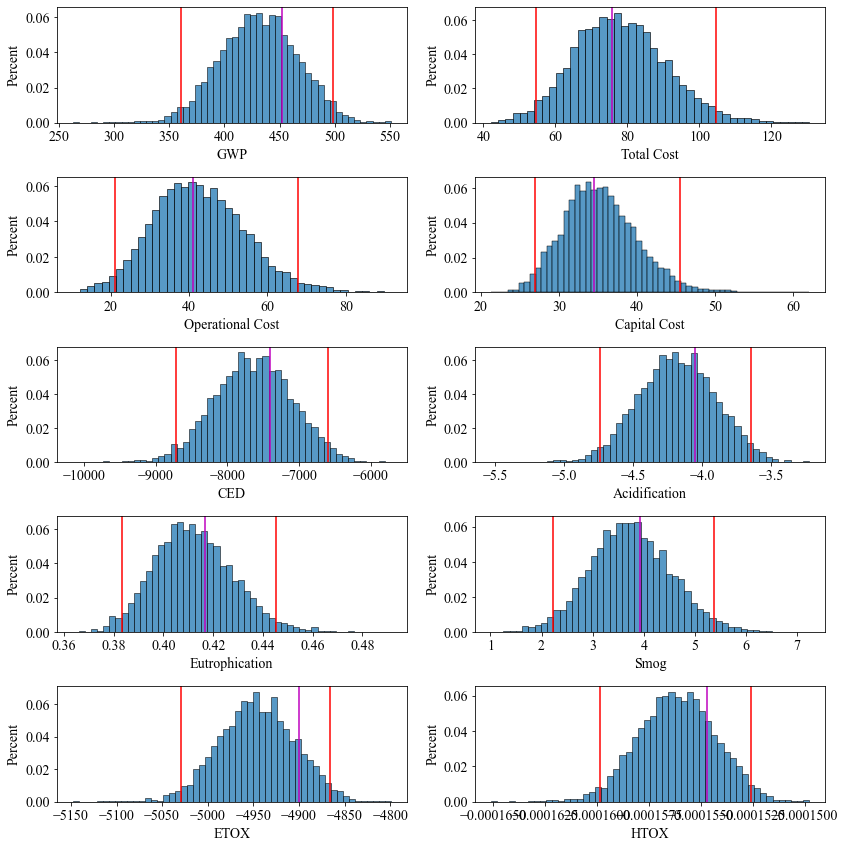

In [20]:
FU = bw2.get_activity(('waste', 'Collection'))
fig, axes = plt.subplots(5, 2, figsize=(12, 12))


lables = ['GWP', 'Total Cost', 'Operational Cost', 'Capital Cost',
          'CED', 'Acidification', 'Eutrophication', 'Smog',
          'ETOX', 'HTOX']

r = 0
c = 0
for m in [ GWP_Method, TotCost_Method, OptCost_Method, CapCost_Method,
           CED_Method, ACID_Method, ETP_Method, SMOG_Method, ETOX_Method,
           HTOX_Method]:
    histdata = mc_results[[m]]/float(FU.as_dict()['unit'].split(' ')[0])
    sns.histplot(data=histdata, x=histdata.columns[0], ax=axes[r][c], stat='probability')
    axes[r][c].set_xlabel(lables[c + r * 2])
    axes[r][c].set_ylabel('Percent')
    axes[r][c].xaxis.tick_bottom()
    axes[r][c].yaxis.tick_left()
    
    lca.switch_method(m)
    lca.lcia()
    axes[r][c].axvline(lca.score/float(FU.as_dict()['unit'].split(' ')[0]), c='m')
    
    axes[r][c].axvline(stats.scoreatpercentile(histdata, 2.5), c='r', label='95%\nconfidence\ninterval')
    axes[r][c].axvline(stats.scoreatpercentile(histdata, 97.5), c='r')
    c += 1
    if c==2:
        r += 1
        c = 0

fig.tight_layout()

#fig.savefig('MC_Dist',dpi=600, bbox_inches='tight')